# Predicting prices of milk, corn, hay, and beef using an ARIMA model

In [1]:
from hmmlearn import hmm
from scipy.stats.distributions import norm
from scipy.optimize import fmin
from scipy.optimize import minimize
from scipy import linalg as la
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
from statsmodels.tsa.base.datetools import dates_from_str
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.dpi'] = 600
plt.rc('font', size=15) #controls default text size
plt.rc('axes', titlesize=15) #fontsize of the title
plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
plt.rc('legend', fontsize=12) #fontsize of the legend

### Load in the data to be used in all of the following methods

In [9]:
data = pd.read_csv('cleaned_data_new.csv')

### Trying ARMA

This attempt aims to predict future prices of the commodities by fitting the data to a ARMA model using VARMAX, and then having the model run for a certain number of months into the future

In [10]:
def sm_varma(start = '1995-07-01', end = '2022-05-01'):
    """
    Build an ARMA model with statsmodel and
    predict future n values.
​
    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting
​
    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    df = pd.read_csv('cleaned_data_new.csv')
    # Create DateTimeIndex
    dates = df['DATE'].astype(str)
    #dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    # Select columns used in prediction
    df = df[['milk','hay','corn','beef']]
    
    model = VARMAX(df[['milk','hay','corn','beef']], trend='n')
    model = model.fit(maxiter=1000, disp=False, ic='aic')
    predict = model.predict(start, end)
    
    # Get CI
    forecast_obj = model.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)
    
    # Plot
    fig, ax = plt.subplots(2,2, figsize=(18,10))
    # Plot milk
    ax[0,0].plot(df['milk'])
    ax[0,0].plot(predict['milk'][1:])
    ax[0,0].plot(all_CI['upper milk'], '--', c='green')
    ax[0,0].plot(all_CI['lower milk'], '--', c='green')
    ax[0,0].legend(['Actual Price', 'Forecast Price', '$95\%$ C.I.'])
    ax[0,0].set_ylabel('USD per Gallon')
    ax[0,0].set_title('Milk')

    # Plot hay
    ax[0,1].plot(df['hay'])
    ax[0,1].plot(predict['hay'][1:])
    ax[0,1].plot(all_CI['upper hay'], '--', c='green')
    ax[0,1].plot(all_CI['lower hay'], '--', c='green')
    ax[0,1].legend(['Actual Price', 'Forecast Price', '$95\%$ C.I.'])
    ax[0,1].set_ylabel('Producer Price Index')
    ax[0,1].set_title('Hay')
    
    # Plot corn
    ax[1,0].plot(df['corn'])
    ax[1,0].plot(predict['corn'][1:])
    ax[1,0].plot(all_CI['upper corn'], '--', c='green')
    ax[1,0].plot(all_CI['lower corn'], '--', c='green')
    ax[1,0].legend(['Actual Price', 'Forecast Price', '$95\%$ C.I.'])
    ax[1,0].set_ylabel('USD per Metric Ton')
    ax[1,0].set_title('Corn')
    
    # Plot beef
    ax[1,1].plot(df['beef'])
    ax[1,1].plot(predict['beef'][1:])
    ax[1,1].plot(all_CI['upper beef'], '--', c='green')
    ax[1,1].plot(all_CI['lower beef'], '--', c='green')
    ax[1,1].legend(['Actual Price', 'Forecast Price', '$95\%$ C.I.'])
    ax[1,1].set_ylabel('Cents per Pound')
    ax[1,1].set_title('Beef')
    
    plt.show()
        
    return "Model AIC: " + str(model.aic)

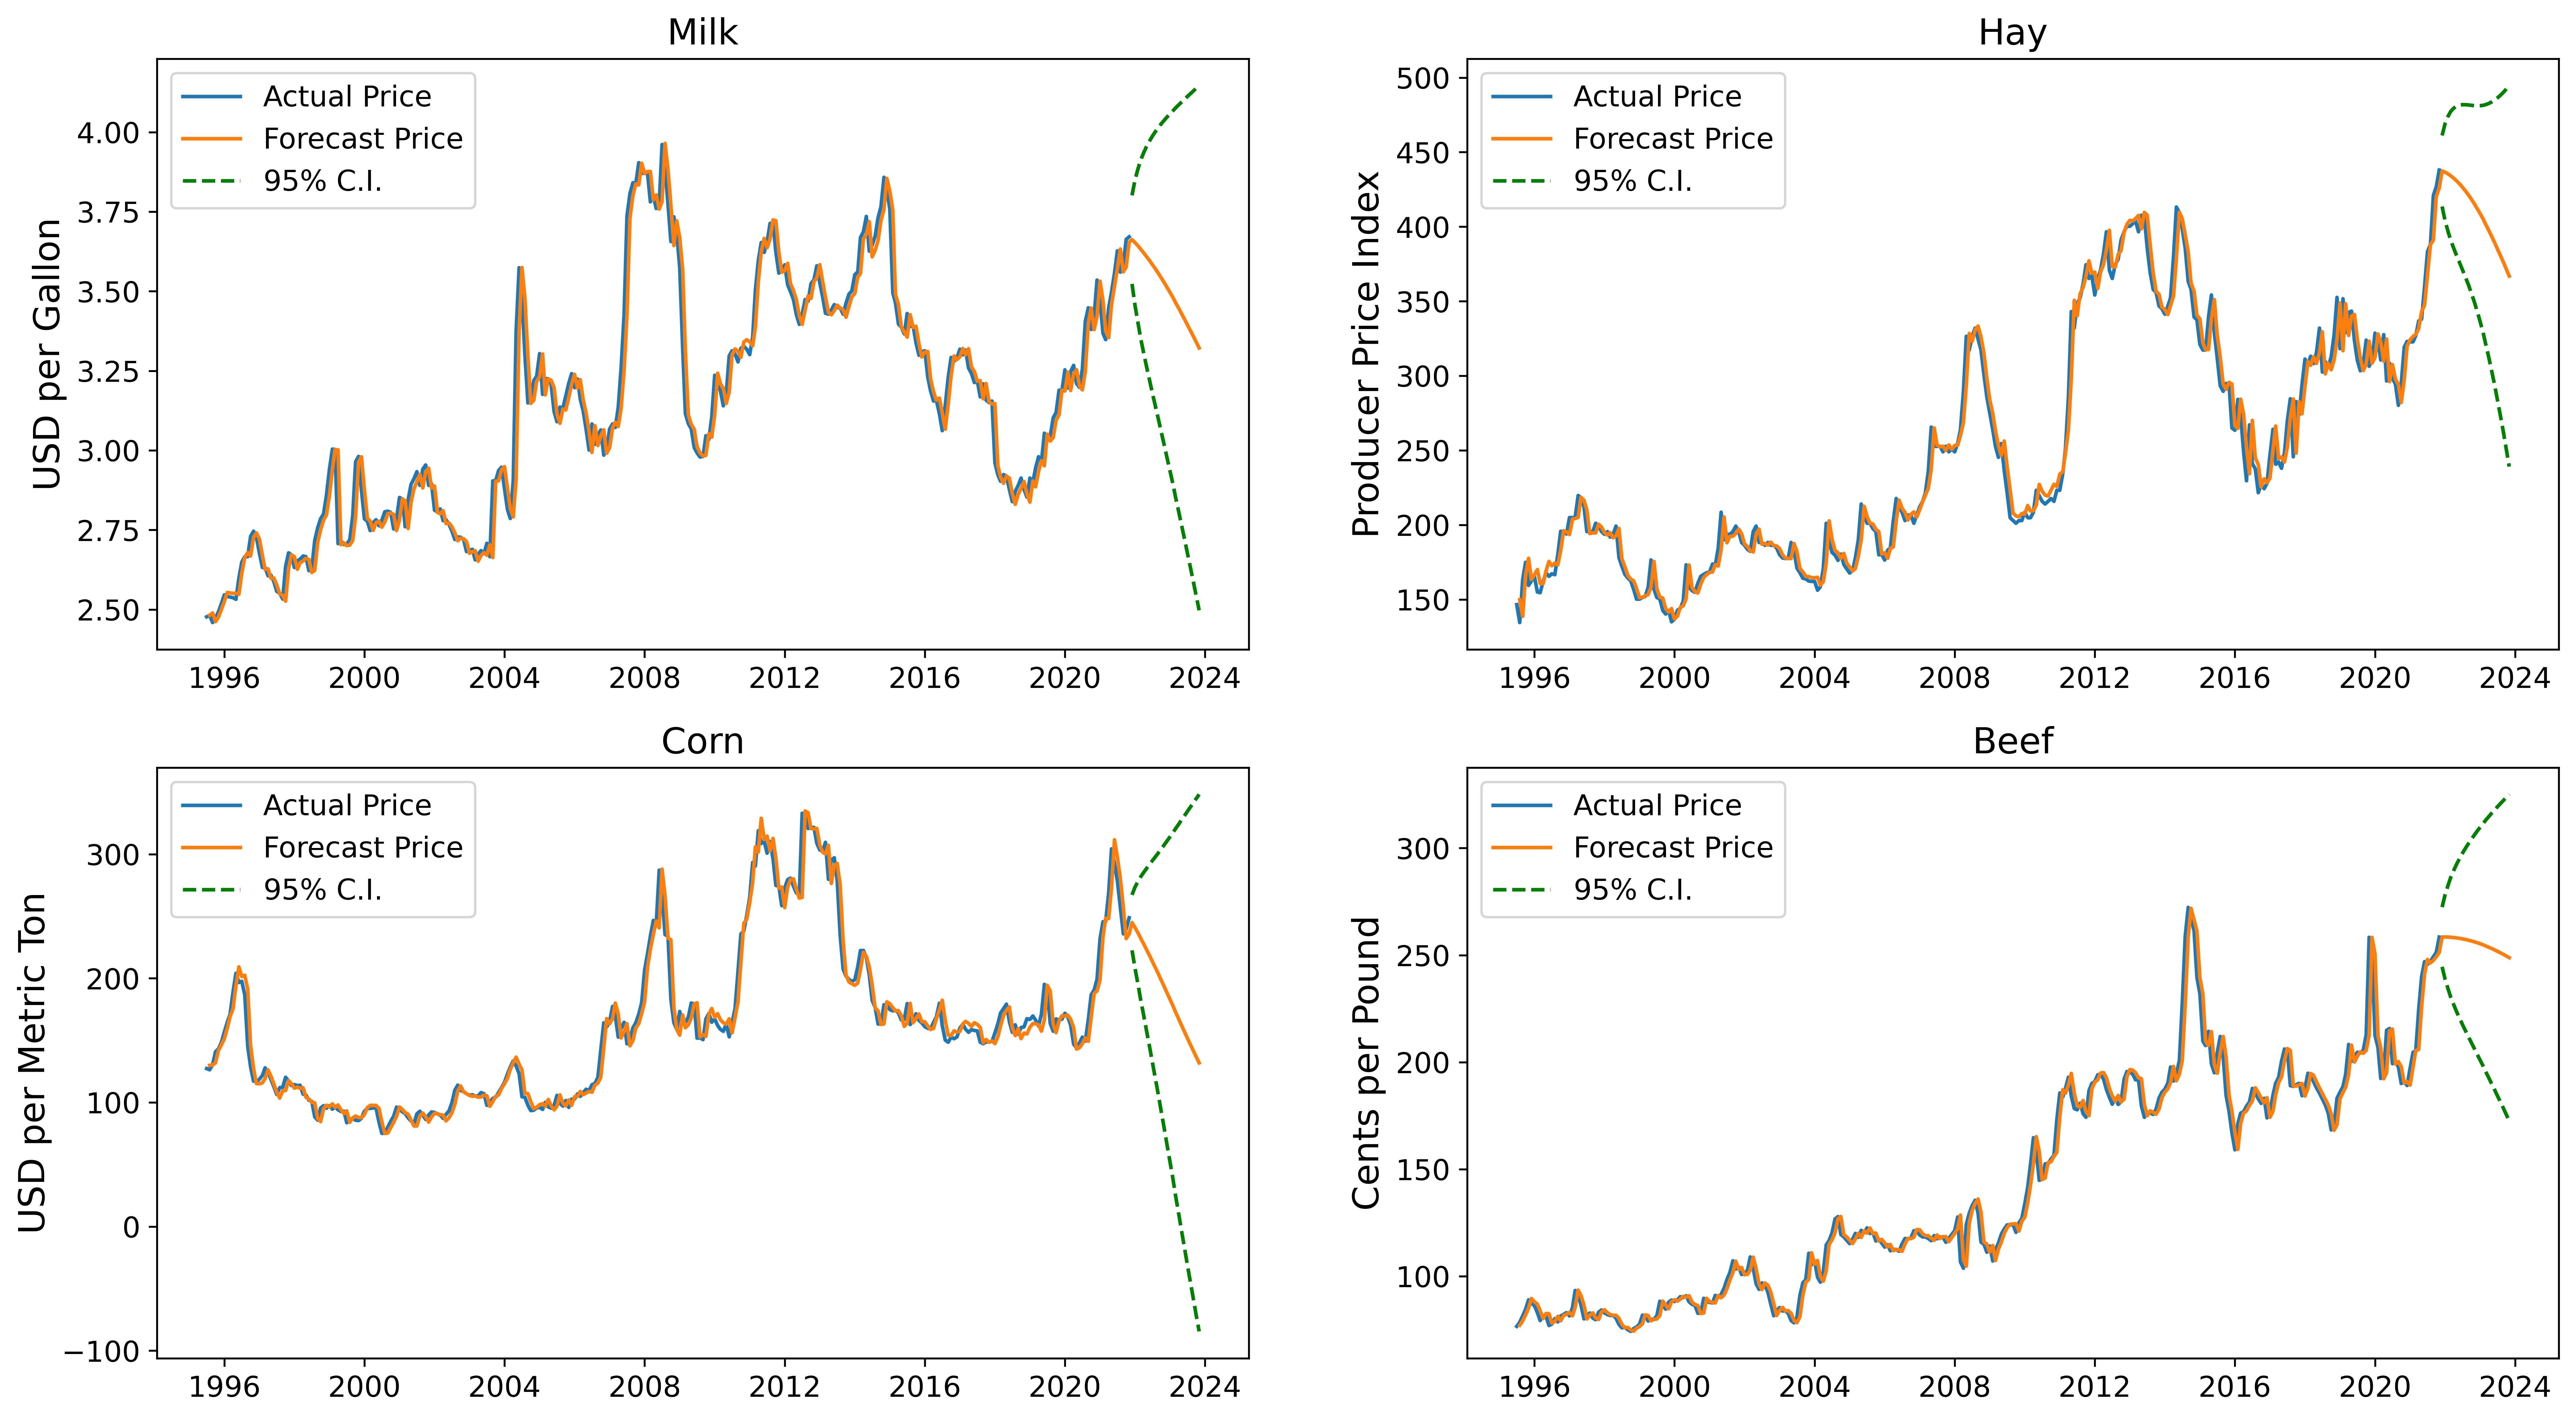

'Model AIC: 6357.522817206948'

In [11]:
sm_varma(end='2023-11-01')

### See how the model performs against the actual data by fitting the model to a training set, forecasting up until the the end of the observed data, and then comparing the model's forecasted values to the actual observed values.

* Using trend='n' within VARMAX()
* Use Mean Squared Error (MSE) to quantify accuracy

In [34]:
def varma_comparison_MLE(start='1995-07-01',end='2021-11-01',train_size=data.shape[0],plot=False):
    """
    Build an ARMA model with statsmodel and
    predict future n values.
​
    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting
​
    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    data = pd.read_csv('cleaned_data_new.csv') # Use this to compare model performance
    df = data.iloc[:train_size] # Use the truncated observations in the model (data up to 2016-04-01)
    
    # Create DateTimeIndex for data
    dates_data = data['DATE'].astype(str)
    dates_data = dates_from_str(dates_data)
    data.index = pd.DatetimeIndex(dates_data)
    # Select columns used in prediction
    data = data[['milk','hay','corn','beef']]
    
    # Create DateTimeIndex for df
    dates_df = df['DATE'].astype(str)
    dates_df = dates_from_str(dates_df)
    df.index = pd.DatetimeIndex(dates_df)
    # Select columns used in prediction
    df = df[['milk','hay','corn','beef']]
    
    model = VARMAX(df[['milk','hay','corn','beef']], trend='n')
    model = model.fit(maxiter=1000, disp=False, ic='aic')
    predict = model.predict(start, end)
    
    # Get CI
    forecast_obj = model.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)
    
    # Plot
    if plot == True:
        
        fig, ax = plt.subplots(2,2, figsize=(18,10))
        
        # Plot milk
        ax[0,0].plot(data['milk'])
        ax[0,0].plot(predict['milk'][1:])
        ax[0,0].plot(all_CI['upper milk'], '--', c='green')
        ax[0,0].plot(all_CI['lower milk'], '--', c='green')
        ax[0,0].legend(['Actual Price', 'Forecast Price', '$95\%$ Confidence Interval'])
        ax[0,0].set_ylabel('USD per Gallon')
        ax[0,0].set_title('Milk')

        # Plot hay
        ax[0,1].plot(data['hay'])
        ax[0,1].plot(predict['hay'][1:])
        ax[0,1].plot(all_CI['upper hay'], '--', c='green')
        ax[0,1].plot(all_CI['lower hay'], '--', c='green')
        ax[0,1].legend(['Actual Price', 'Forecast Price', '$95\%$ Confidence Interval'])
        ax[0,1].set_ylabel('Producer Price Index')
        ax[0,1].set_title('Hay')

        # Plot corn
        ax[1,0].plot(data['corn'])
        ax[1,0].plot(predict['corn'][1:])
        ax[1,0].plot(all_CI['upper corn'], '--', c='green')
        ax[1,0].plot(all_CI['lower corn'], '--', c='green')
        ax[1,0].legend(['Actual Price', 'Forecast Price', '$95\%$ Confidence Interval'])
        ax[1,0].set_ylabel('USD per Metric Ton')
        ax[1,0].set_title('Corn')

        # Plot beef
        ax[1,1].plot(data['beef'])
        ax[1,1].plot(predict['beef'][1:])
        ax[1,1].plot(all_CI['upper beef'], '--', c='green')
        ax[1,1].plot(all_CI['lower beef'], '--', c='green')
        ax[1,1].legend(['Actual Price', 'Forecast Price', '$95\%$ Confidence Interval'])
        ax[1,1].set_ylabel('Cents per Pound')
        ax[1,1].set_title('Beef')
        
        

        plt.show()
    
    
    return predict



Define a function that calculates the MSE for the model

In [35]:
def MSE(data, prediction, train_size):
    """
    Finds the MSE of our data and given predicted values
    Parameters:
        data (pd.DataFrame): observed prices (rows) of each commodity (cols)
        prediction (pd.DataFrame): forecasted prices of each commodity
        train_size (int): index that data is sliced for comparison to prediction
    Returns:
        errors (list): Mean Squared Error of each commodity
    """
    # Convert the pandas df's into np.array's for easier matrix algebra
    observations = np.array(data[['milk','hay','corn','beef']])
    prediction = np.array(prediction[['milk','hay','corn','beef']])
    errors = []
    
    # Calculate the Mean Squared Error for each commodity
    for i in range(observations.shape[1]):
        errors.append(np.mean((observations[:train_size,i] - prediction[:train_size,i])**2))
        
    return errors
     

Get the predicted values

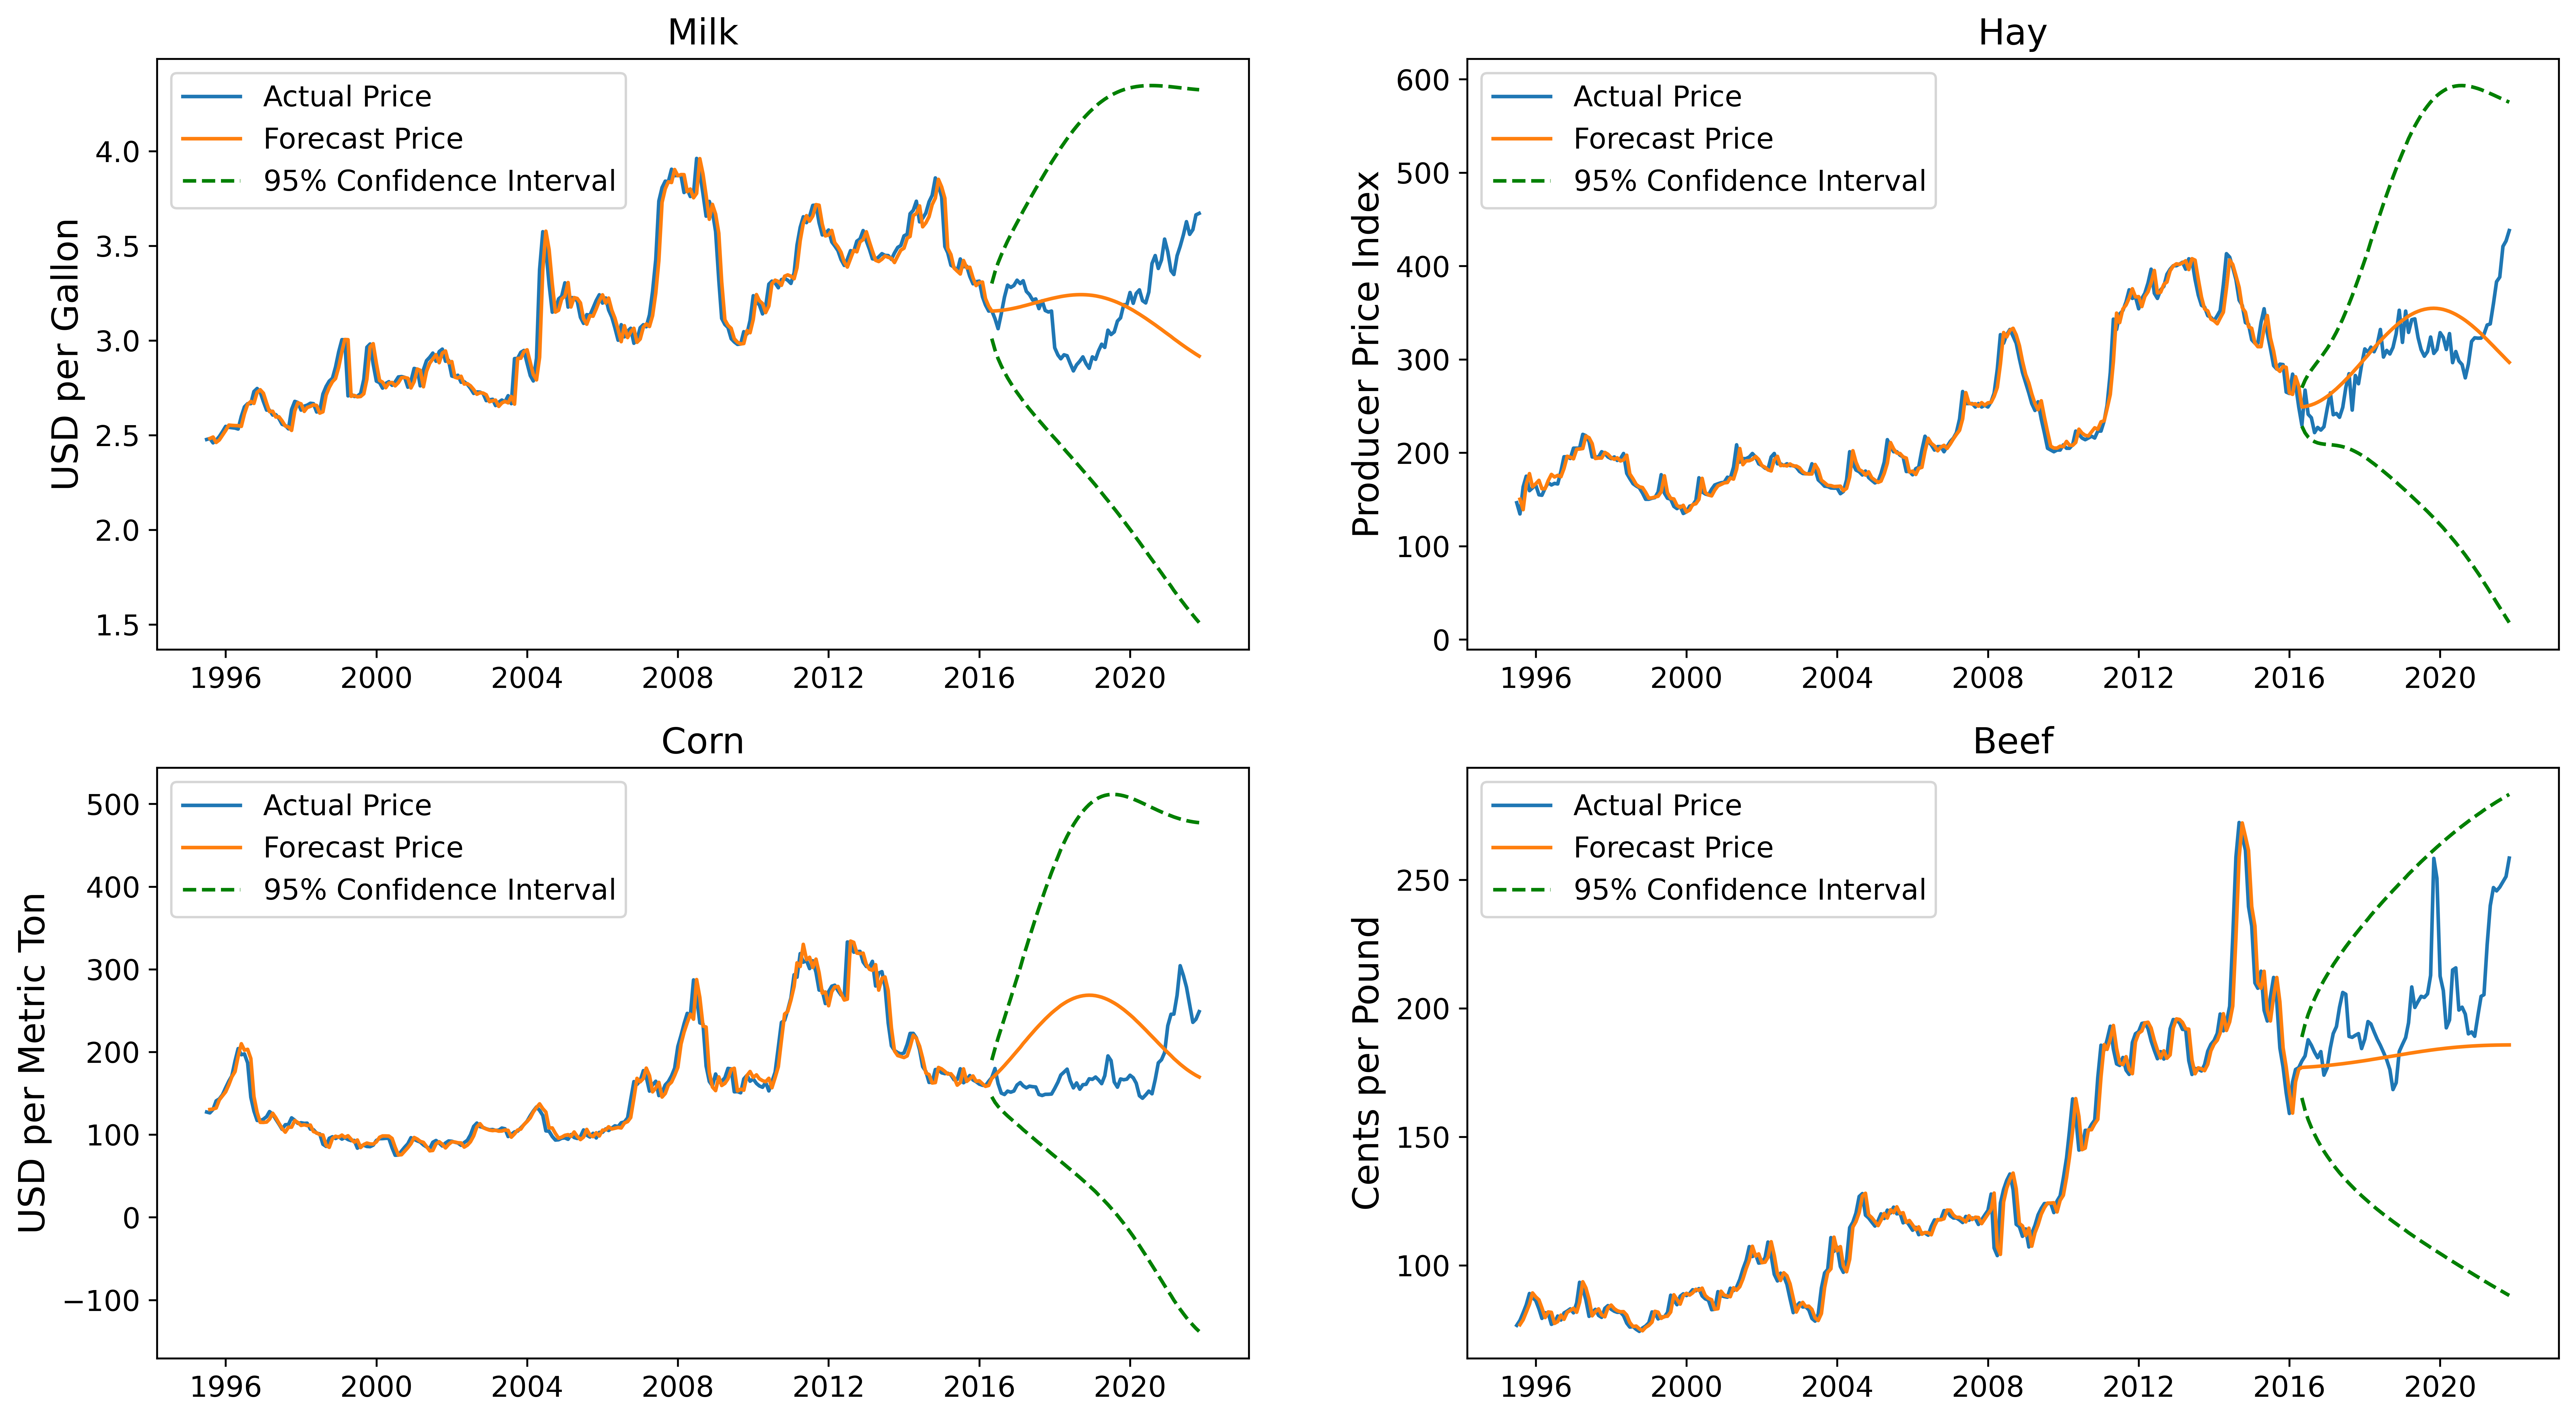

In [36]:
prediction = varma_comparison_MLE(train_size=250,plot=True)

Return MSE for milk, hay, corn, and beef, respectively:

In [37]:
MSE(data, prediction, train_size=250)

[0.02998890371785017,
 194.96106125612963,
 193.36466132578337,
 60.235539251952126]

### Try using VARMAX for just milk and beef with the train/test split from the previous attempt. Could our estimates be better if we don't include all four commodities? Or does our model depend on observations from each of them?

* Using trend = 'n' in VARMAX() method
* Use Mean Squared Error (MSE) to quantify accuracy

In [29]:
def beef_hay_varmax(start = '1995-07-01', end = '2022-05-01', plot=True):
    """
    Build an ARMA model with statsmodel and
    predict future n values.
​
    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting
​
    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    data = pd.read_csv('cleaned_data_new.csv') # Use this to compare model performance
    df = data.iloc[:250] # Use the truncated observations in the model (data up to 2016-04-01)
    
    # Create DateTimeIndex for data
    dates_data = data['DATE'].astype(str)
    dates_data = dates_from_str(dates_data)
    data.index = pd.DatetimeIndex(dates_data)
    # Select columns used in prediction
    data = data[['milk','beef']]
    
    # Create DateTimeIndex for df
    dates_df = df['DATE'].astype(str)
    dates_df = dates_from_str(dates_df)
    df.index = pd.DatetimeIndex(dates_df)
    # Select columns used in prediction
    df = df[['milk','beef']]
    
    model = VARMAX(df[['milk','beef']], trend='n')
    model = model.fit(maxiter=1000, disp=False, ic='aic')
    predict = model.predict(start, end)
    
    # Get CI
    forecast_obj = model.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)
    
    # Plot
    if plot == True:
        fig, ax = plt.subplots(2,1)
        # Plot hay
        ax[0].plot(data['milk'])
        ax[0].plot(predict['milk'][1:])
        ax[0].plot(all_CI['upper milk'], '--', c='green')
        ax[0].plot(all_CI['lower milk'], '--', c='green')
        ax[0].legend(['milk', 'Forecast', '$95\%$ Confidence Interval'])
        ax[0].set_ylabel('USD per Gallon')

        # Plot beef
        ax[1].plot(data['beef'])
        ax[1].plot(predict['beef'][1:])
        ax[1].plot(all_CI['upper beef'], '--', c='green')
        ax[1].plot(all_CI['lower beef'], '--', c='green')
        ax[1].legend(['beef', 'Forecast', '$95\%$ Confidence Interval'])
        ax[1].set_ylabel('Cents per Pound')

        plt.show()
    
    return (predict, model.aic)

In [30]:
def MSE_small(data, prediction, train_size):
    """
    Finds the MSE of our data and given predicted values
    Parameters:
        data (pd.DataFrame): observed prices (rows) of 2 commodities (cols)
        prediction (pd.DataFrame): forecasted prices of 2 commodities
        train_size (int): index that data is sliced for comparison to prediction
    Returns:
        errors (list): Mean Squared Error of both commodities
    """
    # Convert the pandas df's into np.array's for easier matrix algebra
    observations = np.array(data[['milk','beef']])
    prediction = np.array(prediction[['milk','beef']])
    errors = []
    
    # Calculate the Mean Squared Error for each commodity
    for i in range(observations.shape[1]):
        errors.append(np.mean((observations[:train_size,i] - prediction[:train_size,i])**2))
        
    return errors

In [32]:
prediction, aic = beef_hay_varmax(plot=False)

In [33]:
MSE_small(data, prediction, train_size=250)

[0.030076005580514764, 60.28957906846751]

It looks like our model has similar accuracy for milk and beef when we include all four of the commodities. Thus, these 2 commodities depend on each other to some degree. This makes sense since they both come from the cow.

### Can we optimize our model by finding the optimal parameters?

In [38]:
data = pd.read_csv('cleaned_data_new.csv')
np_data = np.array(data[['milk','hay','corn','beef']])
order = order_select(data[['milk']], max_ar=4, max_ma=4, ic=['aic','bic'], fit_kw={'method':'mle'})

print(order['aic_min_order'])
print(order['bic_min_order'])


(3, 3)
(2, 0)


These parameters can be used when initiating our `VARMAX()` model to give the best AIC and BIC, respectively. 